In [739]:
using LinearAlgebra
using Plots
using Measures
#using Kronecker
⊗(a,b) = kron(a,b)

⊗ (generic function with 1 method)

In [373]:
μm = 10^-6; GHz = 1; 

struct DWLattice
    n_racetracks::Int # number of racetracks in unit cell
    racetrack_positions::Vector{Float64}
    orientations::Vector{Int} # relative orientation of each domain wall;
    a::Float64 # lattice constant
    γ::Vector{Float64} # damping constant for each oscillator
    ω₀::Vector{Float64} # resonant frequency of each DW
    PBC::Bool # periodic boundary conditions? for k-dependent hamiltonian?
    C::Float64 # Stray-field coupling constant
    R₀::Float64 # distance between racetracks at which C was calculated
end

function init(; racetrack_positions::Vector{Float64}, orientations::Vector{Int},
        a::Float64, γ::Vector{Float64}, ω₀::Vector{Float64}, PBC::Bool, C::Float64, R₀::Float64)
    return DWLattice(size(racetrack_positions)[1], racetrack_positions, orientations, a, γ, ω₀, PBC, C, R₀);
end    

testSystem = DWLattice(2, [0, 2.5]*μm, [1,-1], 5*μm, [0.1,0.1]*GHz, [10,15]*GHz, true, 10^8, 2.5*μm);

In [804]:
function HO_Hamiltonian(ω₀::Float64,γ::Float64)
    H₀ = [0 1; -ω₀^2 -2*γ]
    #display(H₀)
    return H₀
end

function Coupling_Hamiltonian(C::ComplexF64)
    H = [0 0; C 0]; # adds a term dₜ²x₁ = -ω₀²x₁ - 2γdₜx₁ + C*x₂
    return H
end

function constructHamiltonian(system::DWLattice, NNs::Int)
    function H(k::Union{ComplexF64,Float64})
        H₀ = zeros(ComplexF64,2*system.n_racetracks,2*system.n_racetracks)
        # add oscillators on diagonal
        for i = 1:system.n_racetracks
            ivec = zeros(system.n_racetracks); ivec[i] = 1;
            H₀ += ivec⊗(ivec')⊗HO_Hamiltonian(system.ω₀[i],system.γ[i]) 
        end
        # add coupling between oscillators
        for i = 1:system.n_racetracks
            for j = ((i-NNs):(i-1))∪((i+1):(i+NNs))
                if(j != i)
                    j_index = mod(j-1, system.n_racetracks)+1
                    dR = (floor((j-1)/system.n_racetracks))*system.a # distance of nth unit cell away
                    ΔR = abs(system.racetrack_positions[i] - (dR + system.racetrack_positions[j_index])) # distance of nth racetrack
                    # make huge approximation here, say that Cij decays with 1/r² from calculated
                    # may need minus sign
                    Cij = system.orientations[i]*system.orientations[j_index]*system.C*(system.R₀/ΔR)^(2)
                    Hindex = zeros(system.n_racetracks,system.n_racetracks); Hindex[i,j_index] = 1
                    #println("i = $(i), j = $(j), J_index = $(j_index)")
                    if(j < 1 || j > system.n_racetracks)
                        if(system.PBC)
                            H₀ += Hindex⊗Coupling_Hamiltonian(Cij*exp(im*k*dR))
                            #println("k⋅dR/(2π) = $(k*dR/(2*π))")
                        end
                    else
                        H₀ += Hindex⊗Coupling_Hamiltonian(Cij)
                    end
                end
            end
        end
        #display(H₀)
        return H₀
    end
    return H
end

constructHamiltonian (generic function with 1 method)

In [805]:
H_AFM_racetrack = constructHamiltonian(testSystem,2)

(::var"#H#215"{DWLattice,Int64}) (generic function with 1 method)

In [889]:
function plot1DBands(H::Function,system::DWLattice,nk::Int,Broadening::Bool=false, nE::Int = 200, DOS=true)
    a = system.a
    kvals = LinRange(-π/a,π/a,nk)
    ys = []
    xs = []
    maxE = maximum(imag.(eigvals(H(π/a)) ∪ eigvals(H(0.0))))
    if(Broadening)
        # get some reasonable maximum for the energies
        Evals = LinRange(0,maxE*1.1,nE)
        n = 2*system.n_racetracks
        bands = zeros(nk,nE)
        plottingBands = zeros(nk,nE)
        @Threads.threads for ik in eachindex(kvals)
            k = kvals[ik]
            Hatk = H(k)
            DOS_k(E) = (-1/π)imag.(tr(inv(E*I(n) - im*Hatk)))
            DOS_k_E = DOS_k.(Evals)
            bands[ik,:] = DOS_k_E
        end
        bands = (1/maximum(bands))*bands
        fig = heatmap(kvals*(a/π), Evals, bands', clims=(0,maximum(bands)), xlabel="k (π/a)", ylabel="Frequency (GHz)")
    end
    @Threads.threads for k in kvals
        Es = imag(eigvals(H(k)))
        append!(ys,Es/GHz)
        append!(xs,k*ones(size(Es)))
    end
    fig = scatter!(xs*(a/π),ys, legend=false,ylims=(-0.001,maxE*1.1), xlims=(-1,1), c="white", markersize=2.0, markerstrokewidth=0)
    if(DOS)
        DOS_tot = [sum(bands[:,iE]) for iE = 1:nE]; DOS_tot = (1/maximum(DOS_tot))*DOS_tot
        fDOS = plot(DOS_tot,Evals,legend=false,xlabel="DOS(ω)", ylabel="Frequency (GHz)",ylims=(-0.0001,maxE*1.1),xlims=(0,1))
    end
    fig2 = plot(fig,fDOS,layout=grid(1,2, widths=(5/8,3/8)), size=(800,300),margin=5mm)
    return fig2
end

function getBands(system::DWLattice,NNs::Int,broadening::Bool=false)
    H = constructHamiltonian(system,NNs)
    fig = plot1DBands(H,system,200,broadening)
    #display(fig)
end

getBands (generic function with 4 methods)

In [902]:
#getBands(DWLattice(2, [0, 2.5]*μm, [1,-1], 5*μm, 0.1*[1,1]*GHz, 0*[2.1,2]*GHz, true, 2*GHz, 2.0*μm),1,true);

AFM2R_lattice = init(racetrack_positions=[0, 2.6]*μm, orientations=[1,-1], 
    a=5*μm, γ=0.5*[1,1]*GHz, ω₀=1.0*[9,8]*GHz, PBC=true, C=10.0*GHz, R₀=2.5*μm);

AFM3R_lattice = init(racetrack_positions=[0, 2.8, 5.0]*μm, orientations=[1,-1,1], 
    a=7.5*μm, γ=0.5*[1,0.5,1]*GHz, ω₀=10*[0,2.0,2.1]*GHz, PBC=true, C=400.0*GHz, R₀=2.5*μm);
FM1R_lattice = init(racetrack_positions=[0]*μm, orientations=[1], 
    a=5*μm, γ=0.5*[1]*GHz, ω₀=10*[2.0]*GHz, PBC=true, C=80.0*GHz, R₀=2.5*μm);

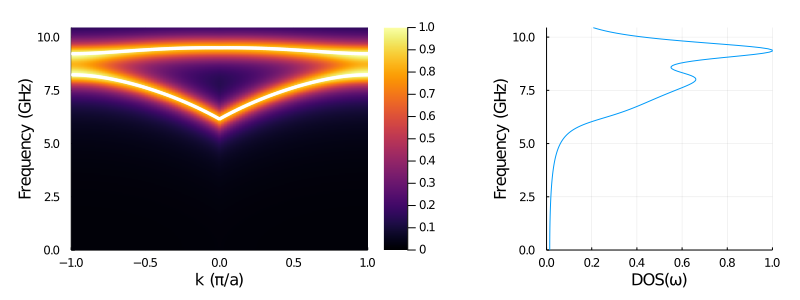

In [908]:
getBands(AFM2R_lattice,200,true)

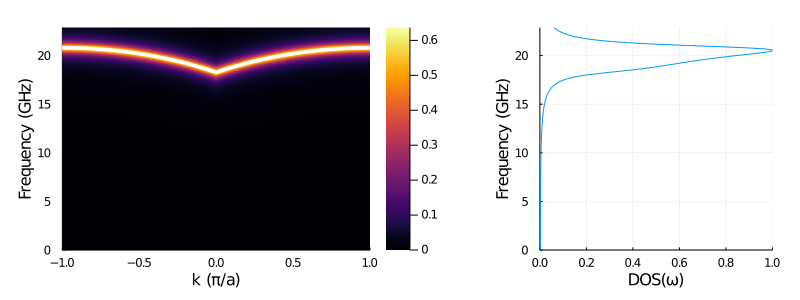

In [881]:
getBands(FM1R_lattice,2000,true)

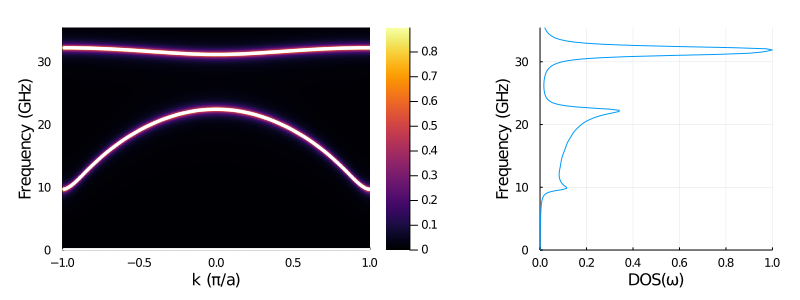

In [883]:
getBands(AFM3R_lattice,50,true)
#plot1DBands(H_AFM_racetrack,testSystem,500,false)
#plot1DBands(H_AFM_racetrack,testSystem,500,true,500)

In [890]:
pinningSweep = @animate for ω₀ in 5*collect(sin.(LinRange(0,π,100)))
    AFM3R_lattice = init(racetrack_positions=[0, 2.8, 5.0]*μm, orientations=[1,-1,1], 
    a=7.5*μm, γ=0.7*[1,0.5,1]*GHz, ω₀=10*[ω₀,2.0,2.1]*GHz, PBC=true, C=400.0*GHz, R₀=2.5*μm);
    getBands(AFM3R_lattice,50,true);
end

Animation("/tmp/jl_rrVqc7", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png"])

┌ Info: Saved animation to 
│   fn = /mnt/c/Users/viv/Documents/inclab/dwlattice/anim_fps15.gif
└ @ Plots /home/viv/.julia/packages/Plots/uCh2y/src/animation.jl:104


Plots.AnimatedGif("/mnt/c/Users/viv/Documents/inclab/dwlattice/anim_fps15.gif")
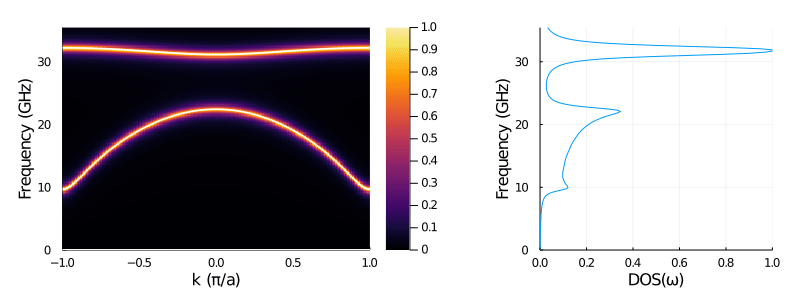

In [891]:
gif(pinningSweep, "anim_fps15.gif", fps = 20)